In [1]:
########## Packages ##########
import numpy as np 
from scipy import stats 
import matplotlib.pyplot as plt 
from sklearn.neighbors import NearestNeighbors

## 3.5 線形回帰の例
- 線形回帰モデルをガウス分布を使って構築
- 係数パラメータの学習
- 未観測データの予測

### 3.5.1 モデルの構築
- 仮定
    - $M = 4$
    - $\boldsymbol{x} = (1, x, x^2, x^3)^{\text{T}}$

次のセルで，$\boldsymbol{w}$の実現値をサンプルし，得られた$\boldsymbol{w}$の値に基づいて3次関数をプロットする．

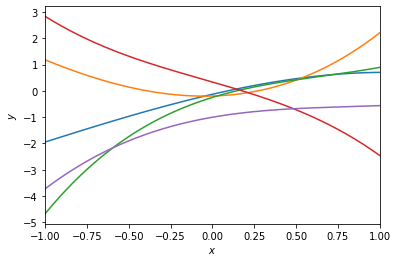

In [2]:
###################### prior distribution ######################
######################## parameter ########################
dim = 4
sample_size = 5
m_vec = np.zeros(dim)  # m = [0, 0, 0, 0]
Lambda_array = np.eye(dim)        # Lambda = diag{1, 1, 1, 1}
###########################################################

################################## generate w ~ p(w) = N(w|0, I) ##################################
w_sample = stats.multivariate_normal(m_vec, np.linalg.inv(Lambda_array)).rvs(size=sample_size)
###################################################################################################

###### generate sample points ######
x_range = np.linspace(-1, 1, 201)
Xvec_set = []
for x in x_range:
    vec = []
    for d in range(dim):
        vec.append(x**d)
    vec = np.array(vec)
    Xvec_set.append(vec)
Xvec_set = np.array(Xvec_set)
####################################

####################### y from prior #######################
y_prior = []
for k in range(sample_size):
    y_prior_sample = []
    for i in range(len(x_range)):
        y_prior_sample.append(w_sample[k].T @ Xvec_set[i])
    y_prior_sample = np.array(y_prior_sample)
    y_prior.append(y_prior_sample)
y_prior = np.array(y_prior)
############################################################

##################### plot x-y from prior model #####################
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel(r"$x$"); ax.set_ylabel(r"$y$")
ax.set_xlim([-1, 1])
for i in range(sample_size):
    ax.plot(x_range, y_prior[i])
plt.show()
#####################################################################


入力値$\boldsymbol{x}_n$を等間隔で何点か与えた上で，人工的な観測値$y_n$をシミュレートしてプロットする．
- 仮定
    - $\lambda = 10.0$

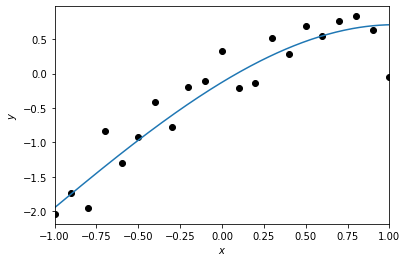

In [3]:
######################## parameter ########################
lambda_precision = 10.0
###########################################################

###### generate input value and mean param ######
x_input = np.linspace(-1, 1, 21)
mean_param_set = []
for x in x_input:
    vec = []
    for d in range(dim):
        vec.append(x**d)
    vec = np.array(vec)
    mean_param_set.append(w_sample[0].T @ vec)
#################################################

#################### generate y_n ~ N(y_n|w^T x_n, \lambda^{-1}) artificially ####################
y_obs_set = []
for i in range(len(x_input)):
    y_obs = stats.norm.rvs(loc=mean_param_set[i], scale=np.sqrt(lambda_precision**(-1)))
    y_obs_set.append(y_obs)
y_obs_set = np.array(y_obs_set)
##################################################################################################

##################### plot x-y from sample #####################
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel(r"$x$"); ax.set_ylabel(r"$y$")
ax.set_xlim([-1, 1])
ax.plot(x_range, y_prior[0])                # plot function
ax.scatter(x_input, y_obs_set, color = "k")  # plot sample y_n
plt.show()
################################################################

- 確率分布の組み合わせ方や構成する確率分布の種類，設定する固定パラメータの値を事前に設定することで，1つの確率モデル (データの生成過程に関する1つの仮説) を明記できる．
- モデルから具体的なパラメータやデータのサンプルを得ることで，仮説がカバーしている実現例を視覚的に確認することができる
    - モデル設計の時点でいくつかのサンプルを抽出して，モデルの妥当性を確認するのが賢明である．

### 3.5.2 事後分布と予測分布の計算
- 上記で構築した線形回帰モデルを使って，データを観測したあとの事後分布と予測分布を求める．
    - 補足資料に導出を載せた (```./Chapter3.5.pdf```)．

### 3.5.3 モデルの比較
導出した予測分布を使って，正弦波をもとに作られた$N = 10$個のデータ点を次数の異なる多項式により学習させる．

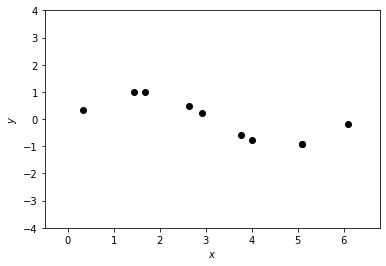

In [4]:
###################### Data from sine wave ######################
num_data = 10           # the number of data
x_data = 2* np.pi * np.random.rand(num_data)
y_data = np.sin(x_data)
#################################################################

###################### plot data ######################
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel(r"$x$"); ax.set_ylabel(r"$y$")
ax.set_xlim([-0.5, 2*np.pi+0.5]); ax.set_ylim([-4, 4])
ax.scatter(x_data, y_data, color = 'k')
plt.show()
#######################################################


In [5]:
###################### prior distribution ######################
######################## parameter ########################
Dim_list = list(range(1, 10))          # dimension
M_vec_list = []; Lambda_array_list = []
for dim in Dim_list:
    M_vec_list.append(np.zeros(dim).reshape(dim,1))        # m = [0, ..., 0]^T
    Lambda_array_list.append(np.eye(dim))   # Lambda = diag{1, ..., 1}
###########################################################


########### function: generate data ###########
# input: dataset (1 dim), dimension (degree - 1)
# output: the set of polynomial data vector
def generate_data(data_x, dim_x):
    data_set = []
    for x in data_x:
        vec = []
        for d in range(dim_x):
            vec.append(x**d)
        data_set.append(np.array(vec).reshape(dim_x,1))
    return np.array(data_set)
###############################################


######################## data vector ########################
X_data_list = []
for dim in Dim_list:
    X_data_list.append(generate_data(data_x=x_data, dim_x=dim))
#############################################################

In [6]:
############# function: post parameter #############
def param_post_norm(lambda_pre, Lambda_matrix, m_vec, data_set_x, data_set_y):
    sm_x = np.zeros_like(Lambda_matrix)
    sm_y = np.zeros_like(m_vec)
    for n in range(len(data_set_x)):
        sm_x += data_set_x[n] @ data_set_x[n].T 
        sm_y += data_set_y[n] * data_set_x[n]
    # Lambda
    hat_Lambda = lambda_pre*sm_x + Lambda_matrix
    # m
    m_first = np.linalg.inv(hat_Lambda)
    m_second = lambda_pre*sm_y + Lambda_matrix @ m_vec
    hat_m = m_first @ m_second
    return hat_Lambda, hat_m 
###################################################


###################### post distribution ######################
hat_Lambda_list = []; hat_m_list = []
for i in range(len(Dim_list)):
    Lambda_hat, m_hat = param_post_norm(lambda_pre=lambda_precision, Lambda_matrix=Lambda_array_list[i], m_vec=M_vec_list[i], data_set_x=X_data_list[i], data_set_y=y_data)
    hat_Lambda_list.append(Lambda_hat)
    hat_m_list.append(m_hat)
###############################################################

In [7]:
###################### predicted distribution ######################
############# generate sample points (x) #############
x_range_input = np.linspace(-0.5, 2*np.pi+0.5, 501)
Xvec_set_sine = []
for dim in Dim_list:
    Xvec_set_sine.append(generate_data(data_x=x_range_input, dim_x=dim))
######################################################


############# function: predict parameter #############
def param_pre_norm(lambda_pre, hat_Lambda, hat_m, data_set_x):
    mu_list = []; err_prs_list = []; err_minus_list = []
    for j in range(len(data_set_x)):
        # mu
        mustr = (hat_m.T @ data_set_x[j])[0][0]
        mu_list.append(mustr)
        # error
        lambdastr_inv = lambda_pre**(-1) + (data_set_x[j].T @ np.linalg.inv(hat_Lambda) @ data_set_x[j])[0][0]
        d_err = np.sqrt(lambdastr_inv)
        err_prs_list.append(mustr + d_err); err_minus_list.append(mustr - d_err)
    return mu_list, err_prs_list, err_minus_list
#######################################################


############# parameters of predicted distribution #############
Post_mu_list = []; Post_err_prs_list = []; Post_err_minus_list = []
for i in range(len(Dim_list)):
    dim_mu_list, dim_err_prs_list, dim_err_minus_list = param_pre_norm(lambda_pre=lambda_precision, hat_Lambda=hat_Lambda_list[i], hat_m=hat_m_list[i], data_set_x=Xvec_set_sine[i])
    Post_mu_list.append(dim_mu_list); Post_err_prs_list.append(dim_err_prs_list); Post_err_minus_list.append(dim_err_minus_list)
################################################################

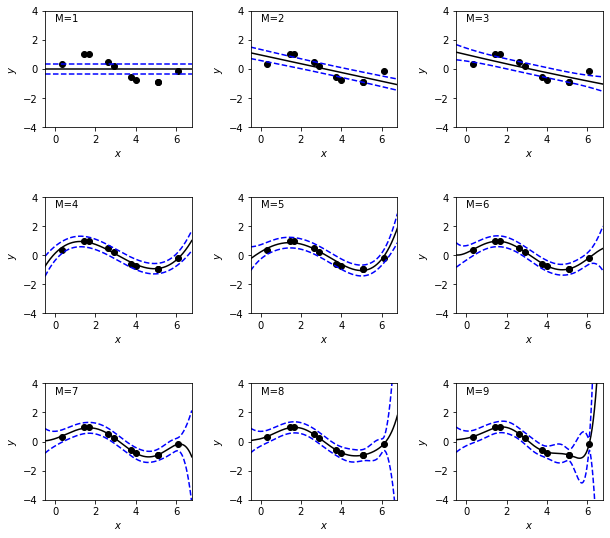

In [8]:
############# split list #############
def split_list(l, n):
    for idx in range(0, len(l), n):
        yield l[idx: idx + n]

split_dim_list = list(split_list(Dim_list, 3))

############# plot #############
fig, axes = plt.subplots(3, 3, figsize=(10,9))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for i in range(len(split_dim_list)):
    for j in range(len(split_dim_list[i])):
        key = i*3 + j; dim = split_dim_list[i][j]
        # plot data
        axes[i][j].set_xlabel(r"$x$"); axes[i][j].set_ylabel(r"$y$")
        axes[i][j].set_xlim([-0.5, 2*np.pi+0.5]); axes[i][j].set_ylim([-4, 4])
        axes[i][j].scatter(x_data, y_data, color = 'k')
        # plot mean parameter
        axes[i][j].plot(x_range_input, Post_mu_list[key], color = 'k')
        # plot error
        axes[i][j].plot(x_range_input, Post_err_prs_list[key], color = 'b', linestyle = 'dashed')
        axes[i][j].plot(x_range_input, Post_err_minus_list[key], color = 'b', linestyle = 'dashed')
        axes[i][j].text(0,3.25,"M={}".format(dim))
plt.show()


上の図から，以下のようなことが分かる．
- 多項式の次数$M$が小さい ($M = 1, 2$) ときは，正弦波の構造を捉えられていない．
- $M = 4, 5$のときは，モデルがデータの上がり下がりの傾向をうまく掴めている．
- 訓練データ数とパラメータ数が近くなる ($M = 8, 9$) と，分散が大きくなる．
    - 予測結果に「自信をもっていない」ことを表している．

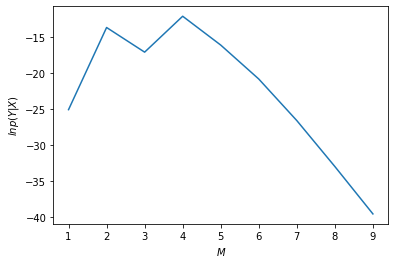

In [9]:
###################### marginal likelihood ######################
term_data = 0
for n in range(num_data):
    term_data += (lambda_precision * y_data[n]**2 - np.log(lambda_precision) + np.log(2*np.pi))

marginal_list = []
for i in range(len(Dim_list)):
    term_quad_1 = (M_vec_list[i].T @ Lambda_array_list[i] @ M_vec_list[i])[0][0]
    term_ln_1 = np.log(np.linalg.det(Lambda_array_list[i]))
    term_quad_2 = (hat_m_list[i].T @ hat_Lambda_list[i] @ hat_m_list[i])[0][0]
    term_ln_2 = np.log(np.linalg.det(hat_Lambda_list[i]))
    mar = -(term_data + term_quad_1 - term_ln_1 - term_quad_2 + term_ln_2)/2
    marginal_list.append(mar)
#################################################################

##################### plot #####################
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel(r"$M$"); ax.set_ylabel(r"$ln p(Y | X)$")
ax.plot(Dim_list, marginal_list)
plt.show()
    

モデルの表現能力と訓練データ数の関係性について，もう1つ例を挙げて確認する．
- 真の関数: 2次関数に正弦波を加えた関数
- 観測データ: 真の関数にノイズ成分が加わった

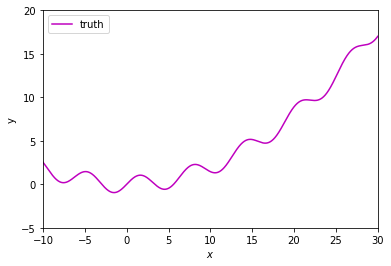

In [10]:
#################### truth function ####################
X_range_quad = np.linspace(-10, 30, 4001)
# truth function f(x) = x^2//50 + sinx
funcf = lambda X: (X**2/50 + np.sin(X))
y_real = funcf(X_range_quad)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel(r"$x$"); ax.set_ylabel(r"y")
ax.set_xlim([-10, 30]); ax.set_ylim([-5, 20])
ax.plot(X_range_quad, y_real, label = "truth", color = 'm')
ax.legend(loc = 'upper left')
plt.show()
########################################################

In [11]:
#################### generate observed data ####################
num_data_list = [3, 10, 50]
x_observed_list = []; y_observed_list = []

##### generate sample points #####
for num in num_data_list:
    # x
    x_obs_data = 40 * np.random.rand(num) - 10     # generate random value in [-10, 30)
    x_observed_list.append(x_obs_data)
##################################

##### generate observed data (random variable) #####
for i in range(len(num_data_list)):
    y_eachnum = []
    for x in x_observed_list[i]:
        # the noise e is assumed to be followed N(e|0, 10^{-1})
        y_observed = stats.norm.rvs(loc=funcf(x), scale=np.sqrt(lambda_precision**(-1)), size=1)[0]
        y_eachnum.append(y_observed)
    y_observed_list.append(y_eachnum)
####################################################

In [12]:
################### 1 degree function ###################
############## x vector ##############
x_line_list = []
for i in range(len(num_data_list)):
    x_line_list.append(generate_data(data_x=x_observed_list[i], dim_x=2))
######################################

# 4/25 ここまで
# for i in range(len(num_data_list)):
    # Lambda_hat, m_hat = param_post_norm(lambda_pre=lambda_precision, Lambda_matrix=Lambda_array_list[1], m_vec=M_vec_list[1], data_set_x=x_line_list[i], data_set_y=y_data)
    

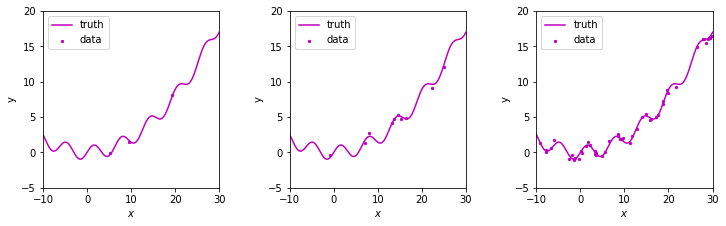

In [13]:
####################### plot #######################
fig, axes = plt.subplots(1, 3, figsize=(12, 3.25))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for i in range(len(num_data_list)):
    axes[i].set_xlabel(r"$x$"); axes[i].set_ylabel(r"y")
    axes[i].set_xlim([-10, 30]); axes[i].set_ylim([-5, 20])
    # plot truth function
    axes[i].plot(X_range_quad, y_real, label = "truth", color = 'm')
    # plot data
    axes[i].scatter(x_observed_list[i], y_observed_list[i], label = "data", s = 5, color = 'm')
    axes[i].legend(loc = 'upper left')
plt.show()
